### Online super scan!

In [456]:
import os
import numpy as np
import scipy
from scipy import optimize, ndimage
import matplotlib.pyplot as plt
import extra_data
import rossendorfer_farbenliste as rofl
from karabo_data import RunDirectory
import mmmUtils as mu


proposal=2806
runNo=513 #RUN containing the scan

step=0.1 #mm ..which distance in Z I will integrate over
onePos=-240   #mm. if set, only one position will be evaluted - used for debugging. Otherwise set negative
plot=0 #intermediate plotes

motor="HED_IA1_NFS/MOTOR/CRL_Z"
cameraA="HED_IA1_JF500K2/DET/JNGFR02:daqOutput" #The camera which is to be evaluated
cameraB="HED_IA1_EPX100-1/DET/RECEIVER:daqOutput" #The camera for KB

run = extra_data.open_run(proposal, runNo, data='raw')  #Opening the given run
outDir='./scans/' #Directory where the results are stored 

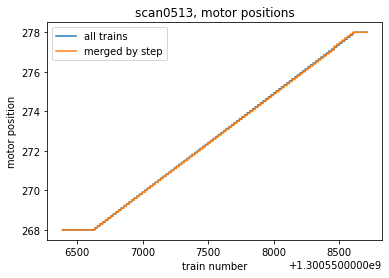

In [457]:
#Preparation: Find the motor positions
prefix='scan{:04d}'.format(runNo)
posMotor=run.get_array(motor,"actualPosition.value")
trainsPos = posMotor.coords['trainId']

pos2=np.round(posMotor/step)*step
unq,inv=np.unique(pos2, return_inverse=1)

plt.plot(trainsPos,posMotor, label='all trains')
plt.plot(trainsPos,pos2, label='merged by step')
plt.legend()
plt.ylabel('motor position')
plt.xlabel('train number')
plt.title(prefix +', motor positions')
plt.legend()
plt.savefig(outDir+prefix+'_positions.tif')
numtrains=np.size(trainsPos)

In [458]:
#Processing the HAPG-KA data
jf =run.get_array(cameraA,"data.adc")  
jf=jf[0:numtrains,:,:] #cuttingimages to use only those where motors were stored

Ameans=np.zeros(np.shape(unq))
Bmeans=np.zeros(np.shape(unq))
rect1=np.array([390,440,880,950]) #pixel coordinates for the zoomed image
rect3=np.array([407,422,600,1024]) #region where i'm getting spectra
speclen=rect3[3]-rect3[2]
profsA=np.zeros((np.size(unq),speclen))
for posi,pos in enumerate(unq):
    if onePos>0:
        if pos!=onePos: #condition if I want to see just one image, otherwise disable
            continue
    posstr="{:2.0f} mm".format(pos)
    #print (posstr)
    sel=inv==posi
    jfsel=jf[sel,:,:]
    jfavg=np.mean(jfsel,axis=0)
    jfavg=jfavg.transpose()
    jfA=mu.cutRect(rect1,jfavg)
    jfC=mu.cutRect(rect3,jfavg)
    prof=np.mean(jfC,1)
    profsA[posi:posi+1,:]=np.transpose(prof,[1,0])    
    if plot:
        plt.figure()   
        plt.rcParams['figure.figsize'] = (12,7)
        plt.subplot(1,2,1)
        plt.title(prefix +'   '+ posstr)
        plt.imshow(jfavg, cmap=rofl.cmap())
        mu.drawRect(rect1)
        mu.drawRect(rect3)
        plt.colorbar()
        plt.clim(0, 1500)
        plt.xlim(300,500)
        plt.ylim(600,1024)
        plt.subplot(1,2,2)
        plt.imshow(jfA, cmap=rofl.cmap())
        plt.clim(-0.5, 1500)
        plt.savefig(outDir+prefix+'_'+posstr+'.tif')
print('done')

done


In [459]:
#Processing the Germanium-KB data
jf =run.get_array(cameraB,'data.image.pixels')  
jf=jf[0:numtrains,:,:] #cuttingimages to use only those where motors were stored

Ameans=np.zeros(np.shape(unq))
Bmeans=np.zeros(np.shape(unq))
rect1=np.array([275,315,0,600]) 
rect3=np.array([275,315,0,600]) 
onePos=-240
speclenB=rect3[3]-rect3[2]
profsB=np.zeros((np.size(unq),speclenB))
for posi,pos in enumerate(unq):
    if onePos>0:
        if pos!=onePos: #condition if I want to see just one image, otherwise disable
            continue
    posstr="{:2.0f} mm".format(pos)
    #print (posstr)
    sel=inv==posi
    jfsel=jf[sel,:,:]
    jfavg=np.mean(jfsel,axis=0)
    jfavg=jfavg.transpose()
    jfA=mu.cutRect(rect1,jfavg)
    jfC=mu.cutRect(rect3,jfavg)
    prof=np.mean(jfC,1)
    profsB[posi,:]=prof.values
    if plot or onePos>0:
        plt.figure()   
        plt.rcParams['figure.figsize'] = (12,7)
        plt.subplot(1,2,1)
        plt.title(prefix +'   '+ posstr)
        plt.imshow(jfavg, cmap=rofl.cmap())
        mu.drawRect(rect1)
        mu.drawRect(rect3)
        plt.colorbar()
        plt.clim(0, 1500)
        plt.xlim(250,350)
        plt.ylim(250,600)

        plt.subplot(1,2,2)
        plt.imshow(np.log10(jfA), cmap=rofl.cmap(),aspect='auto')
        plt.colorbar()
        #plt.clim(0,3000)
        #plt.ylim(0,200)
        
        plt.savefig(outDir+prefix+'_'+posstr+'.tif')
print('done')

done


(100, 600)


/gpfs/exfel/sw/software/xfel_anaconda3/beta/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/gpfs/exfel/sw/software/xfel_anaconda3/beta/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in log10
/gpfs/exfel/sw/software/xfel_anaconda3/beta/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide


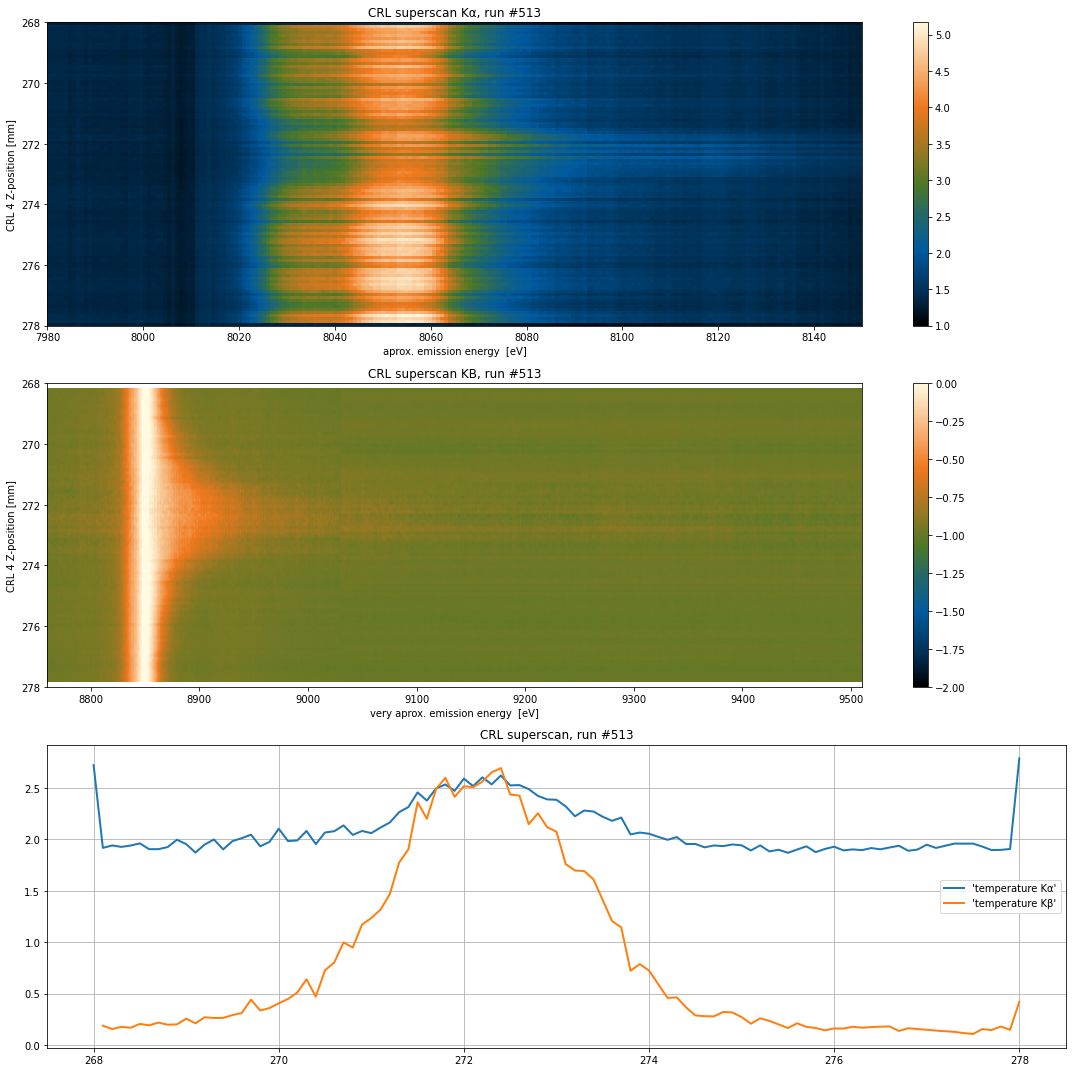

In [460]:
#Do the evaluation and nice output pciture
print(np.shape(profsB))
poss=np.arange(np.shape(profsA)[0])

heatvalsA=poss*0.0
coldvalsA=poss*0.0
heatvalsB=poss*0.0
coldvalsB=poss*0.0

profs2A=profsA*1.0
profs2B=profsB*1.0
plotprofs=0
for i in poss:
    #A
    prof=profsA[i,:]
    if i==0:
        profA0=prof    
#    if np.max(prof)<2:
 #       continue
#   prof=prof-profA0
    prof=prof*-1
    heatvalsA[i]=np.sum(prof[275:300])
    coldvalsA[i]=np.sum(prof[300:325])
    prof=prof/np.max(prof)
    profs2A[i,:]=prof
    if plotprofs:
        plt.plot(prof)

    #B
    prof=profsB[i,:]
    if i==0:
        profB0=prof        
    prof=prof-profB0
#    if np.max(prof)<2:
 #       continue
    heatvalsB[i]=np.sum(prof[470:500])
    coldvalsB[i]=np.sum(prof[520:550])
    prof=prof/np.max(prof)
    profs2B[i,:]=prof

#plt.xlim(200,400)


mu.figure(15,15)
profs3A=np.fliplr(profs2A)
#profs3A=np.log10(profs3A+300)
profs3B=np.fliplr(profs2B)
profs3B=np.log10(profs3B+10e-2)

plt.subplot(3,1,1)
x0=7958
x1=x0+350
extent = x0,x1,unq[-1],unq[0]
plt.imshow(profs3A,cmap=rofl.cmap(),extent=extent,aspect='auto')
plt.xlim(7980,8150)
plt.ylabel('CRL 4 Z-position [mm]')
plt.xlabel('aprox. emission energy  [eV]')
plt.colorbar()
#plt.clim(-2.5,0)
plt.title('CRL superscan Kα, run #{:03.0f}'.format(runNo))

plt.subplot(3,1,2)
x0=8760
disp=25 #eV/mm
disp_px=disp*0.05 #eV/px

x1=x0+speclenB*disp_px 
extent = x0,x1,unq[-1],unq[0]
plt.imshow(profs3B,cmap=rofl.cmap(),extent=extent,aspect='auto')
#plt.xlim(7980,8150)
plt.ylabel('CRL 4 Z-position [mm]')
plt.xlabel('very aprox. emission energy  [eV]')
plt.colorbar()
plt.clim(-2.,0)
plt.title('CRL superscan KB, run #{:03.0f}'.format(runNo))

plt.subplot(3,1,3)
plt.plot(unq,heatvalsA/coldvalsA*3,label="'temperature Kα'",lw=2)
plt.plot(unq,heatvalsB/coldvalsB*6,label="'temperature Kβ'",lw=2)
plt.legend()
plt.grid()
#plt.xlim(240,250)  # adjust the x-axis of the result image
#plt.ylim(0.1,1.8)
plt.title('CRL superscan, run #{:03.0f}'.format(runNo))
plt.tight_layout()
plt.savefig(outDir+'CRL_superscan_run_{:03.0f}.jpg'.format(runNo))

In [444]:
import extra_data as ed
run = ed.open_run(2806,488,data='raw')

In [455]:
run['HED_IA1_JF500K2/DET/JNGFR02:daqOutput','data.adc'].xarray().shape

(200, 1, 512, 1024)

In [454]:
len(run.train_ids)

2760